<a href="https://colab.research.google.com/github/wptaylor/NeurotechUofT/blob/main/Section_3_Working_with_EEG_Data_(Make_a_copy!).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authors: Czarinah Micah Rodriguez, Abhinav Gundrala \\
Source: NeurotechX EEG Notebooks

# Part I: Mini Preprocessing Tutorial

In [ ]:
#@title Run this cell and the cells below. This might take a few minutes.
# Downgrade seaborn and restart runtime
%%capture 
!pip install seaborn==0.9.1

In [ ]:
#@title Install and Import Libraries
%%capture 

!pip install mne
import mne
import numpy as np
%matplotlib inline
 
# Imports
! pip install mne

# System Imports
import os
from glob import glob
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

# Common Imports
import pandas as pd
import numpy as np

# MNE: EEG Analysis Library
from mne import Epochs,find_events

# Specific MNE Imports
from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import make_standard_montage
from mne.preprocessing import ICA

# Download data files
!git clone https://github.com/NeuroTechX/eeg-notebooks.git
!mv ./eeg-notebooks/eegnb ./eegnb

# Install some necessary packages
!pip install psychopy brainflow
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

# Download zip if does not exist
# And unzip
if not os.path.exists('data.zip'):
  !wget -O data.zip https://drive.google.com/uc?id=1oStfxzEqf36R5d-2Auyw4DLnPj9E_FAH
  !unzip data.zip

# Set up virtual display
# (Source: https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy)
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

!pip install pyriemann
import pandas as pd
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

from collections import OrderedDict


import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline
from eegnb.experiments.visual_n170 import n170
from eegnb.analysis import utils


Video available at https://youtube.com/watch?v=Ivq7-fZ62vQ


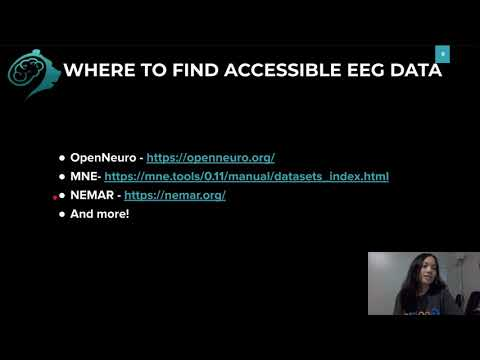

In [ ]:
#@title Video Lesson 9: EEG Tools and Datasets
from IPython.display import YouTubeVideo
video1 = YouTubeVideo(id='Ivq7-fZ62vQ', width=854, height=480, fs=1) 
print("Video available at https://youtube.com/watch?v=" + video1.id)
video1

## Step 1: Visualizing the Raw Data

Now, we have MNE imported into our notebook. Feel free to look at the MNE documentation to learn how to use their functions.  

First, we need our data. Let's write down the path to one of MNE's EEGBCI dataset files using `mne.datasets.eegbci.load_data` (https://mne.tools/stable/generated/mne.datasets.eegbci.load_data.html?highlight=load_data#mne.datasets.eegbci.load_data). 

As you can see from the documentation, there are 109 subjects with multiple runs. You can pick any subject or run that you want to analyze.



In [ ]:
path =  #YOUR CODE HERE 

path[0]
raw = mne.io.read_raw_edf(path[0], preload=True)


Let's look at the metadata for this dataset.

In [ ]:
raw.info

You can see that this tells you the channel names, the number of channels, the sampling frequency, and other types of useful information. You can also get the specific value of a certain information, such as the sampling rate: 

In [ ]:
sampling_rate = raw.info['sfreq']
print("Sampling rate: " + str(sampling_rate))

Now, let's plot the raw data.

In [ ]:
fig = raw.plot(scalings='auto', show=False)
fig.set_size_inches(15, 10)
plt.show()

From the plot, you can see the voltage values for each channel on the y-axis, and time on the x-axis. Remember the International 10-20 system? 

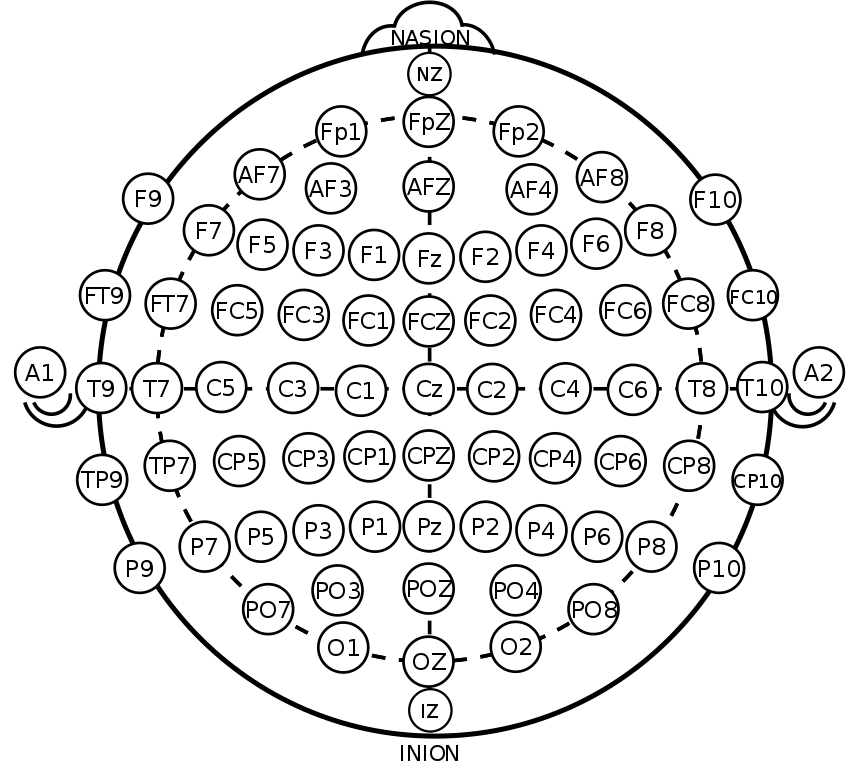

Let's take a peak at the power spectral density (PSD) plot of our data:

In [ ]:
raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=80, average=True, spatial_colors=False);

Interesting! We can see power on the y-axis and frequency on the x-axis. The power for each frequency may depend on the type of data run that you're using. Here's a friendly reminder of the types of brain waves and their frequencies:


*   **Delta waves** (1-4 Hz): slow-wave sleep, deep sleep 
*   **Theta waves** (4-8 Hz): memory encoding, retrieval, mental arithmetic, drowsiness
*  **Alpha waves** (7.5-12.5 Hz): attention and awareness, relaxed wakefulness
*  **Beta waves** (13-30 Hz): concentration, planning and execution of movements
*   **Gamma waves** (30-70Hz): consciousness, perception, sensory processing, information uptake












But wait! Why is there a huge spike at 60 Hz? Is that normal? Well, remember that generally, the electrical circuits surrounding your measurement introduces noise at around 60 Hz. Therefore, we need to use notch filtering, the removal of a single frequency, to remove this artifact in our data. 

## Step 2: Filtering

To do notch filtering, simply use MNE's `notch_filter` on the raw data. 



In [ ]:
raw.notch_filter(#YOUR CODE HERE)

Good! Now, let's look at the notch filtered PSD plot. Notice how it differs from the PSD plot we saw earlier. 

In [ ]:
raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=80, average=True, spatial_colors=False);

## Step 3: Downsampling

Remember a few seconds ago where we defined our sampling rate? Let's downsample the data (reduce the sample rate) to make our data processing more efficient. We try to not downsample it too low so that we can maintain some of the information that is needed. 

Use MNE's `resample` method on the raw data. Set npad='auto' as one of the arguments. I recommend to downsample to 120.

In [ ]:
# YOUR CODE HERE

Let's take a look at our downsampled data. Compare this plot with the previous PSD plots and notice the differences. Think of why these changes occur. 

In [ ]:
raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=60, average=True, spatial_colors=False);

# Notice that the max plotted frequency is 60, the nyquist rate!

## Step 4: Interpolation

After filtering and downsampling, we can look at the raw data again. 

In [ ]:
fig = raw.plot(scalings='auto', show=False)
fig.set_size_inches(15, 10)
plt.show()

You can start checking for bad channels to flag and remove them. I don't know which data you're looking at so you will have to investigate which ones are the bad channels yourself. For now, I'm using dataset where subject=3, run=1. From this data, I notice that C4 looks significantly noisier than the other channels, so I will flag it as a 'bad' channel. Feel free to mark any channels that you think are bad in your data. If you don't know what bad channels look like, I suggest looking at the dataset that I'm using to take a quick look at what C4 looks like.

In [ ]:
raw.info['bads'] += ['C4..']
picks = mne.pick_types(raw.info, exclude='bads')
figure = raw.plot(scalings='auto', show=False)
figure.set_size_inches(15, 10)

Now that we have removed the bad channel(s), we can interpolate the data coming from that channel via spherical spline interpolation. In order to be able to do that, we need to make sure that our channels have location information:

In [ ]:
print(raw.info['chs'])

You can see that all the locations (the 'loc' attributes) are at 0, meaning that we don't have accurate location info. However, assuming that the data was recorded from a headset using the standard 10-20 system, we can load a pre-configured channel location file and use that instead.

In [ ]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.rename_channels(mapping= lambda name: name.replace(".",""))
raw.set_montage(montage, match_case=False)

Now we can interpolate the bad channel and see what the reconstructed channel looks like. 

In [ ]:
raw.interpolate_bads(reset_bads=True)
figure2 = raw.plot(scalings='auto', show=False)
figure2.set_size_inches(15, 10)

## Step 5: Localizing the Signal

Now that we have somewhat cleaned-up data, we can run ICA to try and localize the signal:

In [ ]:
num_components = 15 #play around with this number to get components that seem to represent the actual brain activations well
ica = ICA(n_components=num_components, method='fastica')
ica.fit(raw)

Once the components have been computed, we can plot them on a model of the scalp:

In [ ]:
ica.plot_components();

We can now reject components that appear artifactual. To do so, we can visualize each component's properties first:

Note: If you run the cell and see a bunch of printed words, just ignore them and scroll down to see the figures instead.

In [ ]:
ica.plot_properties(raw, picks=range(num_components));

This might seem like a lot of information. One commonly used heuristic is looking at the spectum of each component. Ideally, each spectrum will have a $\dfrac 1 x$ - like shape:

In [ ]:
ica.plot_properties(raw, picks=7); # This exact component number probably won't work if you recompute ICA


We can now see what our data looks like with the bad component removed. The signals before cleaning are in red and the signals after cleaning are in black. The first plot is for the raw data and the second plot is the average across the EEG channels: 

In [ ]:
ica.plot_overlay(raw, exclude=[9]);

You just learned how to preprocess EEG data! Next, let's dive into an EEG dataset from a famous ERP experiment.

# Part II: Working with the N170 Dataset

Video available at https://youtube.com/watch?v=ANnxqmFBmls


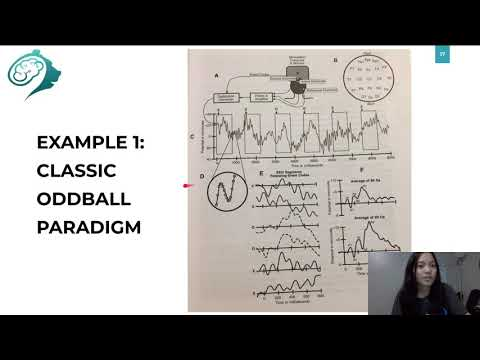

In [ ]:
#@title Video Lesson 10: ERP Experiments
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='ANnxqmFBmls', width=854, height=480, fs=1) 
print("Video available at https://youtube.com/watch?v=" + video.id)
video

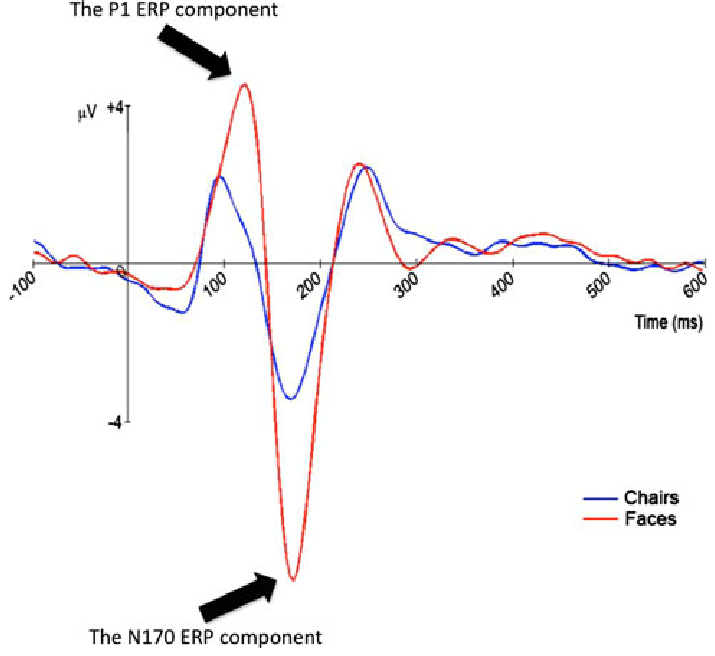

The **N170** is a large negative **event-related potential** (ERP) component that occurs after the detection of faces, but not objects, scrambled faces, or other body parts such as hands. The N170 occurs around 170ms after face perception and is most easily detected at lateral posterior electrodes such as T5 and T6. Frontal or profile views of human (and animal) faces elicit the strongest N170 and the strength of the N170 does not seem to be influenced by how familiar a face is. Thus, although there is no consensus on the specific source of the N170, researchers believe it is related to activity in the fusiform face area, an area of the brain that shows a similar response pattern and is involved in encoding the holistic representation of a face (i.e eyes, nose mouth all arranged in the appropriate way).

In this part, we will attempt to detect the N170 with the Muse headband using faces and houses as our stimuli. The Muse's temporal electrodes (TP9 and TP10) are well positioned to detect the N170 and we expect we'll be able to see an N170 emerge from just a few dozen trials. We will then run several different classification algorithms on our data in order to evaluate the performance of a potential brain-computer interface using the N170.

## Step 1: Prepare the Data for Analysis

As a reminder, MNE is a very powerful Python library for analyzing EEG data. It provides helpful functions for performing key tasks such as filtering EEG data, rejecting artifacts, and grouping EEG data into chunks (epochs).

The following cells will simply load the data into MNE objects. Don't worry if you don't completely understand each line of code. 




In [ ]:
%%capture 

# Session and Subject
session_nb = 1
subject_id = 1

# Create Labels
subject_str = 'subject%04.f' % subject_id
session_str = 'session%03.f' % session_nb
data_path = os.path.join('visual-N170', 'eegnb_examples', 'muse2016', subject_str, session_str, '*.csv')
fnames = glob(data_path)

In [ ]:
%%capture

# Load CSV as MNE Object
# Muse Parameters
ch_ind = [1, 2, 3, 4]
sfreq = 256
n_eeg = len(ch_ind)
n_aux = 0

raws = []
for fn in fnames:
    # Read the file
    data = pd.read_csv(fn)

    # Channel names and types
    ch_names = [list(data.columns)[i] for i in ch_ind] + ['stim']
    print(ch_names)
    ch_types = ['eeg'] * n_eeg + ['misc'] * n_aux + ['stim']

    # Transpose EEG data and convert from uV to Volts
    data = data.values[:, ch_ind + [-1]].T
    data[:-1] *= 1e-6

    # create MNE object
    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq,verbose=1)
    raws.append(RawArray(data=data, info=info, verbose=1))

raws = concatenate_raws(raws, verbose=1)
montage = make_standard_montage('standard_1005')
raws.set_montage(montage)

## Step 2: Visualizing the Power Spectrum

Plotting the power spectral density (PSD) of our dataset will give us a glimpse at the different frequencies that are present. We won't be able to see the N170 in the PSD, but it will give us an impression of how noisy our data was. A very noisy or flat PSD may represent poor signal quality at certain electrodes

In [ ]:
# Plot Power
raws.plot_psd();

This PSD looks good. And again, there is a large peak at 60hz, representing background electrical activity.

## Step 3: Filtering

Instead of doing notch filtering, we'll do something different that can also take care of the electrical noise. Most ERP components are composed of lower frequency fluctuations in the EEG signal. Thus, we can filter out all frequencies between 1 and 30 hz in order to increase our ability to detect them. This is an example of bandpass filtering. 

In [ ]:
raws.filter(1,30, method='iir')
raws.plot_psd(fmin=1, fmax=30);

This PSD of frequencies between 1 and 30 hz looks good. The difference between the temporal channels (red and black) and the frontal channels (blue and green) is clearly evident. The huge peak from 1 to 3hz is largely due to the presence of eye blinks, which produce large amplitude, low-frequency events in the EEG.

## Step 4: Epoching

Next, we will chunk (epoch) the data into segments representing the data 100ms before to 800ms after each stimulus. No baseline correction is needed (signal is bandpass filtered) and we will reject every epoch where the amplitude of the signal exceeded 75 uV, which should most eye blinks.

In [ ]:
# Create an array containing the timestamps and type of each stimulus (i.e. face or house)
events = find_events(raws)
event_id = {'House': 1, 'Face': 2}

# Create an MNE Epochs object representing all the epochs around stimulus presentation
epochs = Epochs(raws, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 75e-6}, preload=True, 
                verbose=False, picks=[0,1,2,3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
epochs

Sample drop % is an important metric representing how noisy our data set was. If this is greater than 20%, consider ensuring that signal variances is very low in the raw EEG viewer and collecting more data. 

## Step 5: Analyze the Data

Finally, we can now analyze our results by averaging the epochs that occured during the different stimuli and looking for differences in the waveform.

With our plot_conditions utility function, we can plot the average ERP for all electrodes for both conditions:

In [ ]:

conditions = OrderedDict()
conditions['House'] = [1]
conditions['Face'] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2))

Here we have a very nice deflection in the temporal channels around 200ms for face stimuli. This is likely the N170, although appearing slightly later due to delay in receiving the data over bluetooth.

There's not much to see in the frontal channels (AF7 and AF8), but that's to be expected based on the fact that the N170 is mostly a lateral posterior brain phenomenon.

## Step 6: Decoding the N170 (ML)

Next, we will use 4 different machine learning pipelines to classify the N170 based on the data we collected. The
 

* **Vect + LR :** Vectorization of the trial + Logistic Regression. This can be considered the standard decoding pipeline for MEG / EEG.
*  **Vect + RegLDA :** Vectorization of the trial + Regularized LDA. This one is very commonly used in P300 BCIs. It can outperform the previous one but become unusable if the number of dimension is too high.
* **ERPCov + TS:** ErpCovariance + Tangent space mapping. One of the most reliable Riemannian geometry-based pipeline.
* **ERPCov + MDM:** ErpCovariance + MDM. A very simple, yet effective (for low channel count), Riemannian geometry classifier.



Evaluation is done through cross-validation, with area-under-the-curve (AUC) as metric (AUC is probably the best metric for binary and unbalanced classification problem)

Note: because we're doing machine learning here, the following cell may take a while to complete

In [ ]:

clfs = OrderedDict()

clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(estimator='oas'), MDM())
clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())

# format data
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, 
                            random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    print(m)
    try:
        
        res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', 
                              cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass

In [ ]:
## Plot Decoding Results

results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

fig = plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.4, 0.9)
sns.despine()

The best classifiers for this data set appear to be the ERPCov and XdawnCov with tangent space projection pipelines. AUC is around .7, which is good, but on the low end for being able to run a brain-computer interface.

Great! Now we're done! 
If you want to see more, you can explore other NeurotechX notebooks here: https://neurotechx.github.io/eeg-notebooks/getting_started/available_notebooks.html

# Summary 

In part 1, you learned how to implement a few MNE preprocessing techniques in order to visualize, filter, downsample, interpolate, and localize signals from an EEG dataset. 

In part 2, you looked at an example of working with an ERP dataset. You saw different ways of doing signal preprocessing and EEG data analysis, including machine learning for decoding the N170. 

Again, there are so many different ways on how you could go about preprocessing your data and doing your analysis. Whenever you work with EEG data, it's important that you're aware of what your code does and how this could affect your analysis. 